In [34]:
import torch.nn as nn
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

In [85]:
latents = np.load('LatentM2S1.npy')
latentsVal = np.load('LatentM2S1Val.npy')
latentsIndex = np.transpose(np.load('LatentIndexM2S1.npy'))[:,0]
latentsIndexVal = np.load('LatentIndexM2S1Val.npy')
rsp = np.load("data/tang_rsp/trainRsp_m2s1.npy")
rspVal = np.load("data/tang_rsp/valRsp_m2s1.npy")

In [86]:
class LatentDecoder(nn.Module):
    """
    This is the q_theta (z|x) network. Given a data sample x q_theta
    maps to the latent space x -> z.

    For a VQ VAE, q_theta outputs parameters of a categorical distribution.

    Inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    - n_res_layers : number of layers to stack

    """

    def __init__(self, rspDim, latentDim, hiddenDim):
        super(LatentDecoder, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(rspDim, hiddenDim//4),
            nn.ReLU(),
            nn.Linear(hiddenDim//4, hiddenDim//2),
            nn.ReLU(),
            nn.Linear(hiddenDim//2, hiddenDim),
            nn.ReLU(),
            nn.Linear(hiddenDim, hiddenDim),
            nn.ReLU(),
            nn.Linear(hiddenDim, hiddenDim//2),
            nn.ReLU(),
            nn.Linear(hiddenDim//2, hiddenDim//4),
            nn.ReLU(),
            nn.Linear(hiddenDim//4, latentDim),
        )


    def forward(self, x):
        #input = torch.flatten(x,start_dim=1)
        return self.layers(x)

In [90]:
training_loader = DataLoader(TensorDataset(torch.Tensor(rsp), torch.Tensor(latentsIndex)), batch_size=64, shuffle=True)
device = 'cuda'
model = LatentDecoder(299,512, 256).to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2e-3)
criterion = torch.nn.CrossEntropyLoss()


In [91]:
for i in range(10000):

    x, latent = next(iter(training_loader))

    x = x.to(device)
    latent = latent.to(device)
    optimizer.zero_grad()

    latentPred = model(x)
    loss = criterion(latentPred, latent)

    loss.backward()
    optimizer.step()

    if i % 50 == 0:
        """
        save model and print values
        """
        torch.save(model.state_dict(),"latentIndexDecoderSave")

        print('Update #', i, 'Recon Error:',
              'Loss', np.mean(loss.item()))

RuntimeError: "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Float'

In [92]:
sampleRsp = torch.reshape(torch.FloatTensor(rsp)[0], (1,299)).to(device)
sampleLatent = latents[0].flatten()
samplePred = model(sampleRsp).detach().cpu().numpy().flatten()



In [56]:
sampleRsp = torch.reshape(torch.FloatTensor(rsp)[0], (1,299)).to(device)
sampleLatentIndex = latentsIndex[0].flatten()
samplePredIndex = model(sampleRsp).detach().cpu().numpy().flatten()

In [12]:
import os
from models.vqvae import VQVAE, VQVAE1d
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import utils
def load_model(model_filename):
    path = os.getcwd() + '/results/'

    if torch.cuda.is_available():
        data = torch.load(path + model_filename)
    else:
        data = torch.load(path + model_filename, map_location=lambda storage, loc: storage)

    params = data["hyperparameters"]

    model = VQVAE(params['n_hiddens'], params['n_residual_hiddens'],
                  params['n_residual_layers'], params['n_embeddings'],
                  params['embedding_dim'], params['beta']).to(device)

    model.load_state_dict(data['model'])

    return model, data
model_filename = 'vqvae_data_mon_feb_6_14_51_08_2023.pth'
vae, _ = load_model(model_filename)
train_data, _, rsp_loader, _, _ = utils.load_data_and_data_loaders('TANGRSP', 32)

torch.Size([32, 1, 299])


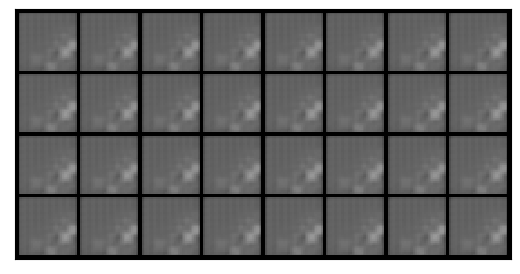

In [13]:
def reconstruct(data_loader,decoder, vae):
    #(x, _) = next(iter(data_loader))
    x = next(iter(data_loader))
    x = x.to(device)
    z_q = decoder(x)
    x_recon = vae.decoder(torch.reshape(z_q, (z_q.shape[0], 6,8,8)))
    return x,x_recon, z_q

def display_image_grid(x):
    x = make_grid(x.cpu().detach())
    x = x.numpy()
    fig = plt.imshow(np.transpose(x, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

x_val,x_val_recon,z_q = reconstruct(rsp_loader,model,vae)
print(x_val.shape)
display_image_grid(x_val_recon)